In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import itertools
import json
import os

import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn
import sklearn.cluster
import torch
import tqdm
import umap

import celltrip


mpl.rcParams['pdf.fonttype'] = 42


# Load Data and Policy

In [3]:
# Read data
adata, = celltrip.utility.processing.read_adatas('s3://nkalafut-celltrip/DrugSeries/expression.h5ad', backed=True)

# Model location and name
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/DrugSeries-251013', 800  # 32 dim - best for interp stages (USE)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/DrugSeries-251110', 800  # 32 dim - sample normalized
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/DrugSeries-251110-cont', 1600  # 32 dim - sample normalized
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/DrugSeries-251110-log', 800  # 32 dim - sample and log normalized
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/DrugSeries-251111-logclip', 800  # 32 dim - sample and log normalized, with clipping
prefix, training_step = 's3://nkalafut-celltrip/checkpoints/DrugSeries-251113-pip', 800  # 32 dim - pipart fix

# Load preprocessing
preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
    mask = np.loadtxt(f).astype(bool)
adata.obs['Training'] = mask

# Create sample env (kind of a dumb workaround, TODO)
m1, = preprocessing.transform([adata[:2].X])
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), compute_rewards=False, dim=32).eval().to('cuda')

# Load policy
policy = celltrip.policy.create_agent_from_env(
    env, forward_batch_size=1_000, vision_size=1_000).eval().to('cuda')
policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');

# Run Untreated and Knockdown

In [68]:
# Parameters
print(adata.obs['treatment'].unique().to_numpy())
series = ['Untreated', 'DMSO', 'Tram']
timesteps = ['3hr', '6hr', '12hr', '24hr', '48hr']

# User-defined
common_mask = np.ones(adata.shape[0], dtype=bool)
# common_mask = adata.obs['cell_line'] == 'CENTRAL_NERVOUS_SYSTEM'
# untreated_target = 'Untreated_48hr'
untreated_target = 'DMSO_48hr'
# untreated_target = 'Tram_3hr'
# knocked_target = 'Tram_3hr'
knocked_target = 'Tram_48hr'
gene_names = ['MAP2K1', 'MAP2K2']  # 'BRAF', 'NRAS', 'KRAS', 'RAF1', 'NF1'

# Functions
preprocess_common = lambda x: preprocessing.inverse_transform(preprocessing.transform([x]))[0]
normalize_counts = lambda x: 10_000 * x / x.sum(keepdims=True, axis=-1)
preprocess_normalize = lambda x: normalize_counts(preprocess_common(x))

['DMSO_48hr' 'Tram_24hr' 'DMSO_12hr' 'Tram_3hr' 'Tram_6hr' 'Tram_12hr'
 'Tram_48hr' 'Untreated_48hr' 'DMSO_3hr' 'DMSO_24hr' 'DMSO_6hr']


## Visualize Distributions

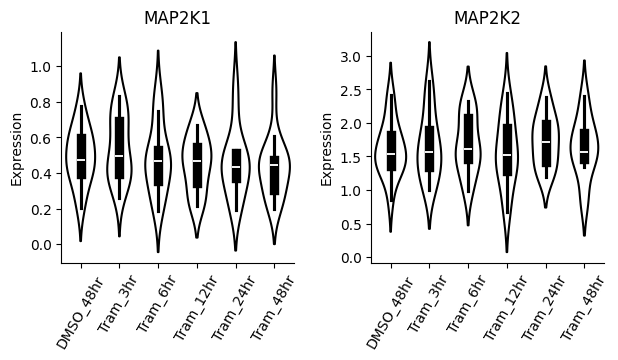

In [ ]:
# Get time series data
# tram_adata = adata[np.argwhere(common_mask*(adata.obs['Drug'] == 'Tram')).flatten()]
target_order = [untreated_target] + [f'Tram_{i}hr' for i in (3, 6, 12, 24, 48)]
dfs = []
for temp_target in target_order:
    mask = np.argwhere(common_mask * (adata.obs['treatment'] == temp_target)).flatten()
    temp_data = np.array(adata[mask].X.todense())
    # temp_data = normalize_counts(temp_data)
    df = pd.DataFrame(temp_data, columns=adata.var['gene_name'])
    df['treatment'] = temp_target
    df['cell_line'] = adata[mask].obs['cell_line'].to_numpy()
    dfs.append(df)
dfs = pd.concat(dfs, axis=0)
dfs = dfs.groupby(['treatment', 'cell_line'], observed=False).mean().reset_index()

# Plot
fig, axs = plt.subplots(1, len(gene_names), figsize=(3*len(gene_names)+1, 3))  # sharey=True
fig.subplots_adjust(wspace=(1/3))
for gene, ax in zip(gene_names, axs):
    sns.violinplot(dfs, x='treatment', y=gene, order=target_order, color='black', fill=False, ax=ax)
    ax.set_title(gene)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
    ax.set_xlabel(None)
    # ax.set_yscale('symlog')
    ax.set_ylabel('Expression')
    sns.despine(ax=ax)
fig.savefig('../plots/drugseries/Gene_Timepoints.pdf')

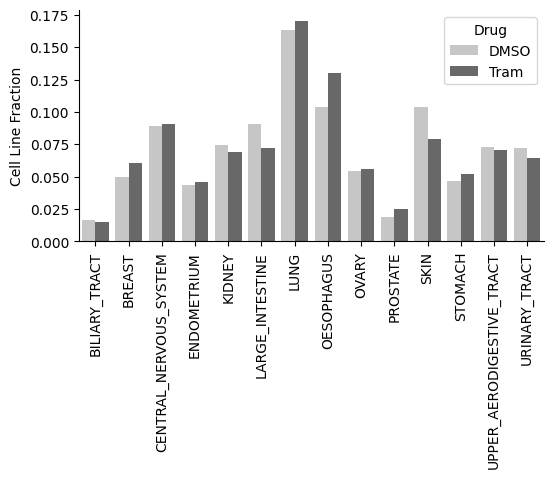

In [6]:
# Get cell line distributions
dfs = []
for drug in ('DMSO', 'Tram'):
    df = adata[adata.obs['Drug'] == drug].obs.groupby(['cell_line'], observed=True).size().reset_index().sort_values(0)
    df = df.rename(columns={'cell_line': 'Cell Line', 0: 'Cell Line Count'})
    df['Cell Line Fraction'] = df['Cell Line Count'] / df['Cell Line Count'].sum()
    df['Drug'] = drug
    dfs.append(df)
dfs = pd.concat(dfs, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(6, 3), sharey=True)
sns.barplot(dfs, x='Cell Line', y='Cell Line Fraction', hue='Drug', palette='Grays', ax=ax)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel(None)
sns.despine(ax=ax)
fig.savefig('../plots/drugseries/Cell_Line_Distribution.pdf')

## Perform Knockdown Simulation

In [7]:
# Get untreated
untreated_idx = adata.obs_names[np.argwhere(common_mask * (adata.obs['treatment'] == untreated_target)).flatten()]
untreated_data = np.array(adata[untreated_idx].X.todense())
# untreated_data = preprocess_common(untreated_data)  # TESTING
untreated_pre, = preprocessing.transform([untreated_data])
env = celltrip.environment.EnvironmentBase(
    torch.tensor(untreated_pre), compute_rewards=False, dim=32).eval(time_scale=5).to('cuda')

# Compute steady state
ret = celltrip.train.simulate_until_completion(
    env, policy, skip_states=100, store_states='cpu', progress_bar=True)
untreated_steady_state_full = ret[-1][-1]
untreated_steady_state = untreated_steady_state_full[..., :env.dim]
with torch.no_grad(): untreated_gex = policy.pinning[0](untreated_steady_state.to('cuda')).detach().cpu().numpy()
untreated_gex, = preprocessing.inverse_transform(untreated_gex, subset_modality=0)

6400it [00:51, 124.45it/s]


In [8]:
# Compute knockdown
skip_states = 32
sim_time = 128.
# adata.var.loc[adata.var['gene_name'] == 'NF1']
# (adata.var['gene_name'].str.contains('RAF1')).sum()

# Get feature targets
gene_idx = adata.var_names[adata.var['gene_name'].isin(gene_names)].to_numpy().astype(int)
knocked_data = np.array(adata[np.argwhere(common_mask * (adata.obs['treatment'] == knocked_target)).flatten()].X.todense())
# knocked_data = preprocess_common(knocked_data)  # TESTING
mean_un = untreated_data[:, gene_idx].mean(keepdims=True, axis=0)
mean_ko = knocked_data[:, gene_idx].mean(keepdims=True, axis=0)
std_un = untreated_data[:, gene_idx].std(keepdims=True, axis=0)
std_ko = knocked_data[:, gene_idx].std(keepdims=True, axis=0)
# feature_targets = np.zeros((1, len(gene_idx)))
feature_targets = knocked_data[:, gene_idx].mean(axis=0)
# feature_targets = np.expand_dims(feature_targets, 0).repeat(944, 0).shape
# feature_targets = np.clip((untreated_data[:, gene_idx] - mean_un) / std_un * std_ko + mean_ko, 0, None)  # Distribution matching

# Time series feature targets
feature_targets_timeseries = []
for temp_target in [untreated_target] + [f'Tram_{i}hr' for i in (3, 6, 12, 24, 48)]:
    temp_data = np.array(
        adata[np.argwhere(
            common_mask * (adata.obs['treatment'] == temp_target)).flatten()]
            .X.todense())
    feature_targets_timeseries.append(temp_data[:, gene_idx].mean(axis=0))
feature_targets_timeseries = np.stack(feature_targets_timeseries, axis=0)
def interp(time):
    return np.array([
                np.interp(time, np.linspace(0, sim_time, 6), feature_targets_timeseries[:, i])
                for i in range(feature_targets_timeseries.shape[1])]),
def nearest(time):
    inverse_idx = (time <= np.linspace(0, sim_time, 6)[1:]).sum()
    return feature_targets_timeseries[-inverse_idx]
def decline(time):
    return feature_targets_timeseries[0] * (1 - time / sim_time)


# CLI
mean_un = untreated_data[:, gene_idx].mean()
mean_knock = (knocked_data[:, gene_idx] - untreated_data[:, gene_idx].mean(axis=0)).mean()
print(f'Observed a mean difference under knockdown of {mean_knock:.2f} from a mean of {mean_un:.2f}')

# Perform simulation
# Set steady state and time
env.reset().set_max_time(sim_time)
env.set_state(untreated_steady_state_full.to('cuda'))
# DMSO
# dmso_data = np.array(adata[np.argwhere(adata.obs['treatment'] == 'DMSO_48hr').flatten()].X.todense())
# dmso_data = preprocess_common(dmso_data)  # TESTING
# # dmso_offset = dmso_data.mean(keepdims=True, axis=0) - untreated_data.mean(keepdims=True, axis=0)
# dmso_offset = preprocessing.transform([dmso_data])[0].mean(keepdims=True, axis=0) - preprocessing.transform([untreated_data])[0].mean(keepdims=True, axis=0)
# env.modality_offsets[0] += torch.tensor(dmso_offset).to('cuda')
# Run
ret = celltrip.train.simulate_until_completion(
    env, policy,
    env_hooks=[
        celltrip.utility.hooks.clamp_input_features_hook(
            gene_idx, preprocessing, feature_targets=0., modality_idx=0,
            device=env.device),
        # celltrip.utility.hooks.clamp_inverted_features_hook(
        #     gene_idx, preprocessing, feature_targets=feature_targets, modality_idx=0),
        # celltrip.utility.hooks.continuous_feature_targets(
        #     celltrip.utility.hooks.clamp_input_features_hook,
        #     # celltrip.utility.hooks.clamp_inverted_features_hook,
        #     interp,
        #     gene_idx, preprocessing, modality_idx=0,
        #     device=env.device,
        # ),
    ],
    action_hooks=[
        # celltrip.utility.hooks.move_toward_targets_hook(
        #     gene_idx, feature_targets=feature_targets, pinning=policy.pinning[0],
        #     preprocessing=preprocessing, modality_idx=0,
        #     factor=1., device=env.device),
        # celltrip.utility.hooks.continuous_feature_targets(
        #     celltrip.utility.hooks.move_toward_targets_hook,
        #     decline,
        #     gene_idx, pinning=policy.pinning[0],
        #     preprocessing=preprocessing, modality_idx=0,
        #     factor=1., device=env.device)
    ],
    skip_states=skip_states, store_states='cpu', progress_bar=True)
knocked_timeseries = ret[-1][..., :env.dim]
with torch.no_grad(): knocked_gex = policy.pinning[0](knocked_timeseries.to('cuda')).detach().cpu().numpy()
knocked_gex, = preprocessing.inverse_transform(knocked_gex, subset_modality=0)


Observed a mean difference under knockdown of -0.21 from a mean of 3.47


1280it [00:10, 122.93it/s]


## Method Comparison

In [58]:
# Save for use by perturbation methods
adata[common_mask].write_h5ad('../plots/drugseries/tram_data.h5ad')

In [61]:
# Load other methods
methods = ('GEARS', 'CPA')
perturbations = {}
perturbations['Unperturbed'] = untreated_data.mean(axis=0)
perturbations['Perturbed'] = knocked_data.mean(axis=0)
perturbations['CellTRIP (No Adj.)'] = knocked_gex[-1].mean(axis=0)
perturbations['CellTRIP (Steady-State Adj.)'] = knocked_gex[-1].mean(axis=0) - (knocked_gex[0].mean(axis=0) - perturbations['Unperturbed'])
perturbations['CellTRIP (PCA Adj.)'] = knocked_gex[-1].mean(axis=0) - (preprocess_common(perturbations['Unperturbed']) - perturbations['Unperturbed'])
for method in methods:
    pert = np.load(f'../plots/drugseries/{method}_perturbation.npy')
    perturbations[method] = pert
perturbations['Only Targets'] = perturbations['Unperturbed'].copy()
perturbations['Only Targets'][gene_idx] = perturbations['Perturbed'][gene_idx]

In [62]:
# Compute results
results = []
for method in list(perturbations.keys())[2:]:
    mse = np.square(perturbations[method] - perturbations['Perturbed']).mean()
    delta = perturbations[method] - perturbations['Unperturbed']
    actual_delta = perturbations['Perturbed'] - perturbations['Unperturbed']
    pdelta = np.corrcoef(delta, actual_delta)[0, 1]
    results.append({'Method': method, 'MSE': mse, 'Pearson Delta': pdelta, 'Mean Abs Delta': np.abs(delta).mean()})
results = pd.DataFrame(results)
results  # Raw MSE and Rel PDelta are most real

,Method,MSE,Pearson Delta,Mean Abs Delta
0,CellTRIP (No Adj.),32.851524,0.441522,0.684883
1,CellTRIP (Steady-State Adj.),4.662159,0.524554,0.012912
2,CellTRIP (PCA Adj.),3.871144,0.649526,0.032793
3,GEARS,68.735825,0.413515,0.807261
4,CPA,5.522619,-0.092383,0.036859
5,Only Targets,5.029932,0.000492,0.000013


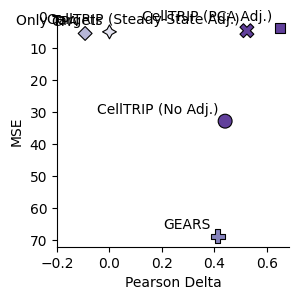

In [67]:
# Method comparison
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
x_var, y_var = 'Pearson Delta', 'MSE'
colors = sns.color_palette('Purples_r', len(results)-2)
colors = 3*[colors[0]] + colors[1:]
sns.scatterplot(
    results, x=x_var, y=y_var, hue='Method',
    hue_order=list(perturbations.keys())[2:], style='Method',
    palette=colors, edgecolor='black', s=100, ax=ax, legend=False)
ax.set_xlim(left=-.2)
ax.set_ylim(bottom=0)
ax.invert_yaxis()
for method in list(perturbations.keys())[2:]:
    row = results.loc[results['Method']==method]
    data_to_axis = ax.transData + ax.transAxes.inverted()
    x, y = data_to_axis.transform([row[x_var], row[y_var]]).flatten()
    ax.text(x-.03, y+.02, method, ha='right', va='bottom', transform=ax.transAxes)
sns.despine(ax=ax)
fig.savefig('../plots/drugseries/Method_Comparison.pdf')

## Visualize

In [13]:
# Calculate pdelta results
# eps = 30  # Minimum var difference for which we should compute correlation
all_treatments = [f'Tram_{t}' for t in timesteps]  # [1:]
pdelta_results = pd.DataFrame(index=all_treatments, columns=skip_states*np.arange(knocked_timeseries.shape[0]), dtype=float)
pert_diffs = []
for treatment in pdelta_results.index:
    # Get actual perturbation delta
    pert_idx = adata.obs_names[np.argwhere(common_mask * (adata.obs['treatment'] == treatment)).flatten()]
    pert_data = np.array(adata[pert_idx].X.todense())
    pert_diff = pert_data.mean(axis=-2) - untreated_data.mean(axis=-2)
    pert_diffs.append(pert_diff)

    # Get predicted perturbation delta
    pred_diff = knocked_gex.mean(axis=-2) - np.expand_dims(untreated_gex, axis=0).mean(axis=-2)
    # pred_diff = knocked_gex.mean(axis=-2) - np.expand_dims(untreated_data, axis=0).mean(axis=-2)
    # pred_diff = knocked_gex.mean(axis=-2) - np.expand_dims(preprocess_common(untreated_data), axis=0).mean(axis=-2)
    # pred_diff = knocked_gex.mean(axis=-2) - knocked_gex[[5]].mean(axis=-2)
    # pred_diff_nan_mask = np.abs(pred_diff).mean(axis=-1) < eps
    # pred_diff_nan_mask = pred_diff.var(axis=-1) < eps

    # Calculate pearson delta for prediction
    pdelta = np.corrcoef(np.expand_dims(pert_diff, axis=0), pred_diff)[0, 1:]  # Not optimal, pdelta
    # pdelta = -np.square(np.expand_dims(pert_diff, axis=0) - pred_diff).mean(axis=-1)  # MSE
    pdelta_results.loc[treatment] = pdelta
    # pdelta_results.loc[treatment, pred_diff_nan_mask] = np.nan  # Mask out unreliably low perturbations

    # Calculate pearson delta for actual
    pdelta = np.corrcoef(np.expand_dims(pert_diff, axis=0), pred_diff)

# Crop first and last timestep - same as untreated and uneven step, respectively
pdelta_results = pdelta_results.iloc[:, 1:-1]

# Get pearson delta for actual
pert_diffs = np.stack(pert_diffs, axis=0)
pdelta = np.corrcoef(pert_diffs)
pdelta_actual = pd.DataFrame(pdelta, index=all_treatments, columns=all_treatments, dtype=float)

# Normalize
# pdelta_results_norm = (pdelta_results - pdelta_results.to_numpy().mean(keepdims=True, axis=1)) / pdelta_results.to_numpy().std(keepdims=True, axis=1)
# pdelta_actual_norm = (pdelta_actual - pdelta_actual.to_numpy().mean(keepdims=True, axis=1)) / pdelta_actual.to_numpy().nanstd(keepdims=True, axis=1)
pdelta_results_rownorm = (pdelta_results - np.nanmean(pdelta_results.to_numpy(), keepdims=True, axis=1)) / np.nanstd(pdelta_results.to_numpy(), keepdims=True, axis=1)
pdelta_actual_rownorm = (pdelta_actual - np.nanmean(pdelta_actual.to_numpy(), keepdims=True, axis=1)) / np.nanstd(pdelta_actual.to_numpy(), keepdims=True, axis=1)
pdelta_results_colnorm = (pdelta_results - np.nanmean(pdelta_results.to_numpy(), keepdims=True, axis=0)) / np.nanstd(pdelta_results.to_numpy(), keepdims=True, axis=0)
pdelta_actual_colnorm = (pdelta_actual - np.nanmean(pdelta_actual.to_numpy(), keepdims=True, axis=0)) / np.nanstd(pdelta_actual.to_numpy(), keepdims=True, axis=0)
pdelta_results_diff = pdelta_results - pdelta_results.to_numpy()[:, [0]]
pdelta_actual_diff = pdelta_actual - pdelta_actual.to_numpy()[:, [0]]
pdelta_results_diff_rowscale = pdelta_results_diff / np.nanstd(pdelta_results_diff.to_numpy(), keepdims=True, axis=1)
pdelta_actual_diff_rowscale = pdelta_actual_diff / np.nanstd(pdelta_actual_diff.to_numpy(), keepdims=True, axis=1)
# pdelta_results_norm = (pdelta_results - pdelta_results.to_numpy().min(keepdims=True, axis=1)) / (pdelta_results.to_numpy().max(keepdims=True, axis=1) - pdelta_results.to_numpy().min(keepdims=True, axis=1))
# pdelta_actual_norm = (pdelta_actual - pdelta_actual.to_numpy().min(keepdims=True, axis=1)) / (pdelta_results.to_numpy().max(keepdims=True, axis=1) - pdelta_results.to_numpy().min(keepdims=True, axis=1))

Using Kernel Size 4
Using Kernel Size 4
Using Kernel Size 4
Using Kernel Size 4


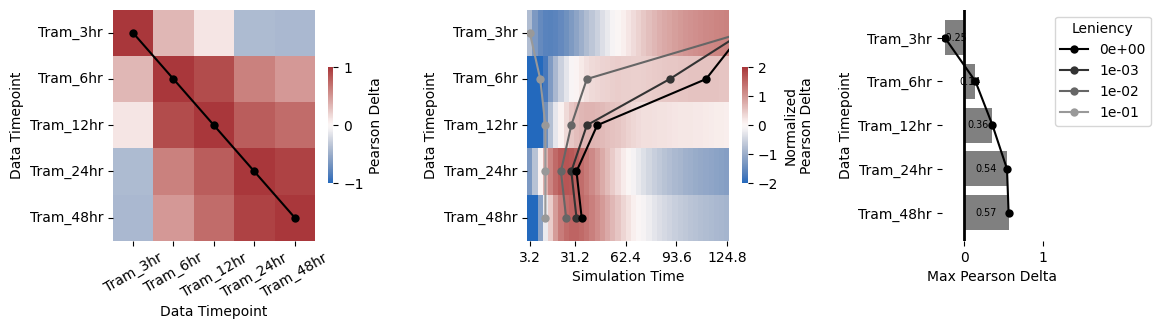

In [14]:
# Create figure
widths = [5, 5, 2]
line_kwargs = dict(marker='o', markersize=6, markeredgecolor='none')
fig, axs = plt.subplots(1, 3, figsize=(sum(widths), 3), width_ratios=widths)
fig.subplots_adjust(wspace=.8)

# Annotate max
num_lines = 4
eps_list = np.concat([np.logspace(-1, -3, num_lines-1, base=10), [0]])
white_list = np.linspace(.6, 0., num_lines)
def get_peak(df, kernel_size=None, eps=1e-2):
    # Default params
    if kernel_size is None:
        kernel_size = np.ceil((10/sim_time)*df.shape[1]).astype(int)
        print(f'Using Kernel Size {kernel_size}')
    # Moving window
    smoothed = np.stack([
        np.convolve(df.to_numpy()[i], np.ones(kernel_size) / kernel_size, mode='full')
        for i in range(df.shape[0])], axis=0)
    return (smoothed >= smoothed.max(keepdims=True, axis=1) - eps).argmax(axis=1)
    # return smoothed.argmax(axis=1)
    # Weighted mean
    # data = df.to_numpy()
    # data = (data - data.min(keepdims=True, axis=1)) / data.std(keepdims=True, axis=1)  # / (data.max(keepdims=True, axis=1) - data.min(keepdims=True, axis=1))
    # data = np.exp(data)  # Scaling exp
    # data = data / data.sum(keepdims=True, axis=1)
    # return (data * np.expand_dims(np.arange(data.shape[1]), axis=0)).sum(axis=1)
    # First to max-eps
    # return (df.to_numpy() >= df.to_numpy().max(keepdims=True, axis=1) - eps).argmax(axis=1)
    # Max
    # return df.to_numpy().argmax(axis=1)

# Reference pdelta heatmap
ax = axs[0]
sns.heatmap(
    pdelta_actual,
    cmap='vlag', vmin=-1, vmax=1,
    cbar_kws={
        'shrink': .5, 'ticks': np.arange(-1, 1.01, 1.),
        'label': 'Pearson Delta'}, ax=ax)
ax.set(xlabel='Data Timepoint', ylabel='Data Timepoint')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
# Annotate max
ax.plot(
    get_peak(pdelta_actual, kernel_size=1, eps=0) + .5,
    np.arange(pdelta_actual.shape[0]) + .5,
    color='black', **line_kwargs)

# Actual pdelta heatmap
ax = axs[1]
# df_use = pdelta_results
df_use = pdelta_results_rownorm
# df_use = pdelta_results_colnorm
# df_use = pdelta_results_diff
# df_use = pdelta_results_diff_rowscale
sns.heatmap(
    df_use,
    cmap='vlag',
    vmin=-2, vmax=2,
    cbar_kws={
        'shrink': .5,
        'ticks': np.arange(-2, 2.01, 1.),
        'label': 'Normalized\nPearson Delta'}, ax=ax)
ax.set(xlabel='Simulation Time', ylabel='Data Timepoint')
xtick_step = df_use.shape[1] / 4
xticks = np.array([1] + np.arange(
    xtick_step, xtick_step*(1+df_use.shape[1]//xtick_step), xtick_step).tolist()) - .5
xticklabels = skip_states * env.delta * (xticks + .5)
xticklabels = [f'{l:.1f}' for l in xticklabels]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=0)
# Annotate max
for eps, white in zip(eps_list, white_list):
    ax.plot(
        get_peak(pdelta_results, eps=eps) + .5,
        np.arange(pdelta_results.shape[0]) + .5,
        color=3*[white], **line_kwargs)

# Peak performance
ax = axs[2]
pdelta_results_max = pdelta_results.max(axis=1).reset_index()
pdelta_results_max.columns = ['Data Timepoint', 'Max Pearson Delta']
bar = sns.barplot(pdelta_results_max, x='Max Pearson Delta', y='Data Timepoint', orient='y', color='gray', ax=ax)
sns.lineplot(pdelta_results_max, x='Max Pearson Delta', y='Data Timepoint', orient='y', color='black', **line_kwargs, ax=ax)
ax.bar_label(bar.containers[0], fmt='{:0.2f}', label_type='center', fontsize='x-small')
# ax.set(ylabel=None, yticklabels=[], yticks=[])
ax.set_xlim(right=1.)
# ax.tick_params(axis='x', which='major', length=0)
ax.axvline(x=0, color='black', lw=2)
sns.despine(left=True, bottom=True)

# Make legend
ax.legend(handles=[
    mpl.lines.Line2D([], [], color=3*[white], **line_kwargs, label=f'{eps:.0e}')
    for eps, white in zip(eps_list, white_list)][::-1],
    loc='upper left', bbox_to_anchor=(1.05, 1.), title='Leniency')

fig.savefig('../plots/drugseries/Timed_Pearson_Delta.pdf')

In [15]:
pdelta_results

,32,64,96,128,160,192,224,256,288,320,...,960,992,1024,1056,1088,1120,1152,1184,1216,1248
Tram_3hr,-0.312485,-0.328518,-0.335820,-0.339680,-0.340324,-0.339223,-0.336656,-0.332974,-0.328118,-0.323497,...,-0.253759,-0.252221,-0.250924,-0.249834,-0.248892,-0.248033,-0.247255,-0.246547,-0.245904,-0.245323
Tram_6hr,0.073264,0.078359,0.090773,0.101955,0.111332,0.118669,0.124500,0.128967,0.132735,0.135114,...,0.143742,0.143968,0.144099,0.144145,0.144133,0.144097,0.144049,0.143995,0.143929,0.143867
Tram_12hr,0.295148,0.302712,0.317134,0.329514,0.339159,0.346239,0.351456,0.355030,0.357678,0.358932,...,0.353242,0.353222,0.353153,0.353032,0.352879,0.352715,0.352550,0.352391,0.352228,0.352080
Tram_24hr,0.486677,0.498026,0.513698,0.526453,0.535239,0.540846,0.543946,0.544908,0.544353,0.542643,...,0.494838,0.493905,0.493068,0.492308,0.491605,0.490943,0.490329,0.489760,0.489230,0.488749
Tram_48hr,0.496880,0.503546,0.520494,0.535893,0.547371,0.555491,0.560877,0.563868,0.565142,0.565010,...,0.529654,0.528943,0.528305,0.527720,0.527175,0.526658,0.526173,0.525721,0.525299,0.524915


In [ ]:
# assert False

AssertionError: 

# Run Interpolation on 24hr

In [20]:
# Load sample-normalized model
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/DrugSeries-251110', 700  # 32 dim - sample-normalized
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/DrugSeries-251110-cont', 1600  # 32 dim - sample-normalized
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/DrugSeries-251110-log', 800  # 32 dim - sample and log normalized (USE)
# preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
# policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');

In [21]:
# adata.obs.groupby('cell_line').size()

In [23]:
# Determine stages to interpolate
drug, start_time, interp_time, end_time = 'Tram', '12hr', '24hr', '48hr'
start_stage, interp_stage, end_stage = f'{drug}_{start_time}', f'{drug}_{interp_time}', f'{drug}_{end_time}'

# Get known data
common_mask = True
# common_mask = adata.obs['cell_line'] == 'LUNG'
start_exp = np.array(adata[common_mask * (adata.obs['treatment']==start_stage)].X.todense())
interp_exp = np.array(adata[common_mask * (adata.obs['treatment']==interp_stage)].X.todense())
end_exp = np.array(adata[common_mask * (adata.obs['treatment']==end_stage)].X.todense())

# Use K-Means to create start and end pseudocells
start_n_pcells = end_n_pcells = min([exp.shape[0] for exp in (start_exp, interp_exp, end_exp)])  # 500
start_pcell_ids = sklearn.cluster.KMeans(n_clusters=start_n_pcells, random_state=42).fit_predict(start_exp)
end_pcell_ids = sklearn.cluster.KMeans(n_clusters=end_n_pcells, random_state=42).fit_predict(end_exp)
print(f'Chose {start_n_pcells}-{end_n_pcells} cells')

# Get expression and spatial for pseudocells
start_processed_exp = np.stack([start_exp[np.argwhere(start_pcell_ids==i).flatten()].mean(axis=0) for i in range(start_n_pcells)], axis=0)
end_processed_exp = np.stack([end_exp[np.argwhere(end_pcell_ids==i).flatten()].mean(axis=0) for i in range(end_n_pcells)], axis=0)

# Calculate OT matrix
a, b, _, OT_mat = celltrip.utility.general.compute_discrete_ot_matrix(start_processed_exp, end_processed_exp)

# Calculate pseudocells
pcells = [([i], np.argwhere(OT_mat[i] > 0).flatten()) for i in range(OT_mat.shape[0]) if OT_mat[i].sum() > 0]
start_pcells_exp, end_pcells_exp = [], []
start_pcells_obs, end_pcells_obs = [], []
for pcell_start, pcell_end in pcells:
    start_pcells_exp.append(start_processed_exp[pcell_start].mean(axis=0))
    end_pcells_exp.append(end_processed_exp[pcell_end].mean(axis=0))
start_pcells_exp = np.stack(start_pcells_exp, axis=0)
end_pcells_exp = np.stack(end_pcells_exp, axis=0)

# Run to initial steady state
start_m1, = preprocessing.transform([start_pcells_exp])
env = celltrip.environment.EnvironmentBase(
    torch.tensor(start_m1), compute_rewards=False, dim=env.dim).eval(time_scale=5).to('cuda')
env.reset()
celltrip.train.simulate_until_completion(env, policy, store_states=False, progress_bar=True)

# Get transition states
end_m1, = preprocessing.transform([end_pcells_exp])
env.set_modalities([torch.tensor(end_m1)]).set_max_time(64.).to('cuda')
env.time = 0  # Reset timing
transition_skip = 20
transition_states = celltrip.train.simulate_until_completion(env, policy, skip_states=transition_skip, store_states='cpu', progress_bar=True)[-1][..., :env.dim].cpu()
num_even_states = env.max_time / (transition_skip * env.delta)
transition_sim_time = (transition_skip * env.delta * np.arange(num_even_states+1)).tolist()
if num_even_states != int(num_even_states): transition_sim_time += [env.max_time]
transition_sim_time = np.array(transition_sim_time)

# Impute
with torch.no_grad(): transition_states_exp = policy.pinning[0](transition_states.to('cuda')).detach().cpu().numpy()
transition_states_exp, = preprocessing.inverse_transform(transition_states_exp, subset_modality=0)


Chose 948-948 cells


6400it [00:17, 367.04it/s]
640it [00:01, 363.94it/s]


/home/ubuntu/miniconda3/envs/celltrip/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Distance by Timepoint: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


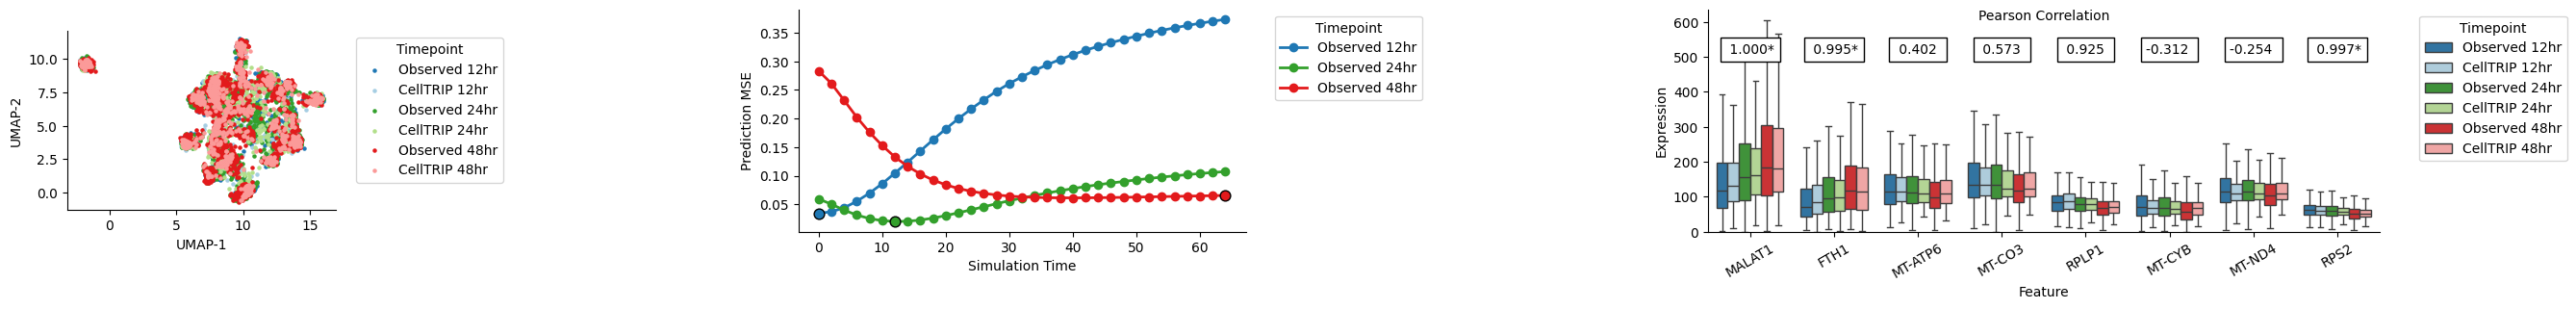

In [ ]:
# Generate figure
widths = [6, 10, 15]
fig, axs = plt.subplots(1, 3, figsize=(sum(widths), 3), width_ratios=widths)
fig.subplots_adjust(wspace=1.)
# Result tuples
point_tuples = [
    # ('Observed 12hr', start_exp),
    # ('Observed 24hr', interp_exp),
    # ('Observed 48hr', end_exp)]
    ('Observed 12hr', normalize_counts(start_exp)),
    ('Observed 24hr', normalize_counts(interp_exp)),
    ('Observed 48hr', normalize_counts(end_exp))]
    # ('Observed 12hr', preprocessing.transform([start_exp])[0]),
    # ('Observed 24hr', preprocessing.transform([interp_exp])[0]),
    # ('Observed 48hr', preprocessing.transform([end_exp])[0])]
celltrip_transition_idx = 6
celltrip_tuples = [
    ('CellTRIP 12hr', transition_states_exp[0]),
    ('CellTRIP 24hr', transition_states_exp[celltrip_transition_idx]),
    ('CellTRIP 48hr', transition_states_exp[-1])]
    # ('CellTRIP 12hr', preprocess_common(transition_states_exp[0])),
    # ('CellTRIP 24hr', preprocess_common(transition_states_exp[3])),
    # ('CellTRIP 48hr', preprocess_common(transition_states_exp[-1]))]
    # ('CellTRIP 12hr', preprocessing.transform([transition_states_exp[0]])[0]),
    # ('CellTRIP 24hr', preprocessing.transform([transition_states_exp[3]])[0]),
    # ('CellTRIP 48hr', preprocessing.transform([transition_states_exp[-1]])[0])]
# Combine tuples
all_tuples = point_tuples + celltrip_tuples
all_tuples = list(all_tuples[::3]) + list(all_tuples[1::3]) + list(all_tuples[2::3])
# Paired colors
all_colors = sns.color_palette('Paired', 6)
colors = list(all_colors[1::2]) + list(all_colors[::2])
all_colors = list(colors[::3]) + list(colors[1::3]) + list(colors[2::3])

# UMAP
ax = axs[0]
reduction = umap.UMAP(n_neighbors=200, random_state=42).fit(np.concat(list(map(lambda t: t[1], point_tuples)), axis=0))
for (name, points), color in tqdm.tqdm(zip(all_tuples, all_colors), desc='UMAP Transform', total=len(all_tuples)):
    ax.scatter(*reduction.transform(points).T, s=5., color=color, label=name)
ax.set_aspect('equal')
sns.despine(ax=ax)
ax.set(xlabel='UMAP-1', ylabel='UMAP-2')
ax.legend(title='Timepoint', loc='upper left', bbox_to_anchor=(1.05, 1.))

# Distance by timepoint
ax = axs[1]
for i, (name, points) in tqdm.tqdm(enumerate(point_tuples), desc='Distance by Timepoint', total=len(point_tuples)):
    # Get error
    # err = np.square(transition_states_exp - np.expand_dims(points, axis=0)).mean(axis=(-2, -1))
    # emd = np.array([celltrip.utility.distance.compute_emd(tse, points) for tse in transition_states_exp])  # EMD
    mse = np.square(transition_states_exp.mean(axis=1) - points.mean(keepdims=True, axis=0)).mean(axis=-1)  # MSE
    # err = np.array([
    #     celltrip.utility.distance.compute_emd(tse, preprocessing.transform([points])[0])
    #     for tse in preprocessing.transform([
    #         transition_states_exp.reshape([-1, transition_states_exp.shape[-1]])])[0].reshape([
    #             *transition_states_exp.shape[:2], -1])])
    err = mse
    # Plot
    ax.plot(transition_sim_time, err, color=colors[i], lw=2, marker='o', markersize=6, label=f'{name}')
    # ax.plot(transition_sim_time, mse, color=colors[i], lw=2, ls='--', markersize=6, label=f'{name} - MSE')
    if name == 'Observed 12hr':
        ax.scatter(transition_sim_time[[0]], err[[0]], color=all_colors[2*i], edgecolors='black', marker='o', s=60, zorder=2)
    elif name == 'Observed 24hr':
        if celltrip_transition_idx == 'auto':
            celltrip_transition_idx = err.argmin()
        ax.scatter(transition_sim_time[[celltrip_transition_idx]], err[[celltrip_transition_idx]], color=all_colors[2*i], edgecolors='black', marker='o', s=60, zorder=2)
    elif name == 'Observed 48hr':
        ax.scatter(transition_sim_time[[-1]], err[[-1]], color=all_colors[2*i], edgecolors='black', marker='o', s=60, zorder=2)
# Format
sns.despine(ax=ax)
ax.set(xlabel='Simulation Time', ylabel='Prediction MSE')
ax.legend(title='Timepoint', loc='upper left', bbox_to_anchor=(1.05, 1.))

# Sample gene distances
ax = axs[2]
interp_distribution = []
# Choose genes
assert preprocessing.filter_mask[0] is None
# chosen_gene_idx = np.random.choice(start_exp.shape[1], 8)  # Random
# chosen_gene_idx = preprocessing.standardize_std[0].argsort()[::-1].flatten()[:8]  # Top variant
# chosen_gene_idx = np.abs(end_exp.mean(axis=0) - start_exp.mean(axis=0)).argsort()[::-1][:8]  # Top varying by mean across stages
chosen_gene_idx = np.abs(np.median(end_exp, axis=0) - np.median(start_exp, axis=0)).argsort()[::-1][:8]  # Top varying by median across stages
chosen_genes = adata.var.loc[adata.var_names[chosen_gene_idx], 'gene_name'].tolist()
# chosen_genes = ['MAP2K1', 'MAP2K2']; chosen_gene_idx = [np.argmax(adata.var['gene_name']==gene) for gene in chosen_genes]  # Manual
for name, points in all_tuples:
    df = pd.DataFrame(points[:, chosen_gene_idx], columns=chosen_genes)
    df['Timepoint'] = name
    interp_distribution.append(df)
# Format df
interp_distribution = (
    pd.concat(interp_distribution, axis=0)
    .melt(id_vars='Timepoint', var_name='Feature', value_name='Expression'))
# Plot
box = sns.boxplot(
    interp_distribution, x='Feature', y='Expression', hue='Timepoint',
    hue_order=list(map(lambda a: a[0], all_tuples)), palette=all_colors,
    showfliers=False, ax=ax)
# Compute correlation for each gene
gene_corr = {}
for gene in chosen_genes:
    timepoint_expression = interp_distribution.loc[interp_distribution['Feature'] == gene]
    # Relies on sorting of input tuples
    # timepoint_expression = timepoint_expression.groupby('Timepoint')['Expression'].mean()  # Use means
    timepoint_expression = timepoint_expression.groupby('Timepoint')['Expression'].median()  # Use medians
    gene_corr[gene] = scipy.stats.pearsonr(
        timepoint_expression.loc[timepoint_expression.index.str.startswith('Observed')],
        timepoint_expression.loc[timepoint_expression.index.str.startswith('CellTRIP')],
        alternative='greater')
    # Oversampling
    # timepoint_expression = timepoint_expression.set_index('Timepoint')
    # timepoint_expression_observed = timepoint_expression.loc[timepoint_expression.index.str.startswith('Observed'), 'Expression']
    # timepoint_expression_celltrip = timepoint_expression.loc[timepoint_expression.index.str.startswith('CellTRIP'), 'Expression']
    # timepoint_expression_observed_idx, timepoint_expression_celltrip_idx = [], []
    # for timepoint_observed, timepoint_celltrip in zip(timepoint_expression_observed.index.unique(), timepoint_expression_celltrip.index.unique()):
    #     timepoint_expression_observed_idx.append(np.argwhere(timepoint_expression_observed.index==timepoint_observed).flatten())
    #     timepoint_expression_celltrip_idx.append(np.argwhere(timepoint_expression_celltrip.index==timepoint_celltrip).flatten())
    #     maxlen = max(timepoint_expression_observed_idx[-1].shape[0], timepoint_expression_celltrip_idx[-1].shape[0])
    #     timepoint_expression_observed_idx[-1] = timepoint_expression_observed_idx[-1][np.arange(maxlen) % timepoint_expression_observed_idx[-1].shape[0]]
    #     timepoint_expression_celltrip_idx[-1] = timepoint_expression_celltrip_idx[-1][np.arange(maxlen) % timepoint_expression_celltrip_idx[-1].shape[0]]
    # timepoint_expression_observed_idx = np.concat(timepoint_expression_observed_idx, axis=0)
    # timepoint_expression_celltrip_idx = np.concat(timepoint_expression_celltrip_idx, axis=0)
    # gene_corr[gene] = scipy.stats.pearsonr(
    #     timepoint_expression_observed.iloc[timepoint_expression_observed_idx],
    #     timepoint_expression_celltrip.iloc[timepoint_expression_celltrip_idx],
    #     alternative='greater')
# Annotate
ax.text(
    .5, 1., f'Pearson Correlation', ha='center', va='top', transform=ax.transAxes)
for i, gene in enumerate(chosen_genes):
    corr, p = gene_corr[gene].statistic, gene_corr[gene].pvalue
    corr_str = f'{gene_corr[gene].statistic: >6.3f}'
    corr_str += '*' if p < .05 else ' '
    ax.text(
        i, .85, corr_str, ha='center', va='top',
        bbox=dict(facecolor='white', edgecolor='black'),
        transform=mpl.transforms.blended_transform_factory(ax.transData, ax.transAxes))
# Format
# ax.set_ylabel('Count-Normalized Expression')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
sns.despine(ax=ax)
sns.move_legend(box, loc='upper left', bbox_to_anchor=(1.05, 1.))
ax.set_ylim(bottom=0)

fig.savefig('../plots/drugseries/Interpolation_Performance.pdf')
